In [ ]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os
import random
from tensorflow.keras.preprocessing import image

In [ ]:

data_dir = 'C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data'  

# Create a dataset for the entire data to use for split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=13
)
# Calculate the total number of samples
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()

train_size = int(0.8 * total_samples)                 # 70% for training
val_size   = int(0.15 * total_samples)                # 20% for validation
test_size = total_samples - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset.take(train_size)
validation_dataset  = full_dataset.skip(train_size).take(val_size)
test_dataset        = full_dataset.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(13) ==> {train_size*13}")
print(f"Validation samples: {val_size}       batches(13) ==> {val_size*13}")
print(f"Test samples:       {test_size}      batches(13) ==> {test_size*13}")


Found 17353 files belonging to 2 classes.
Train samples:      1068     batches(13) ==> 13884
Validation samples: 200       batches(13) ==> 2600
Test samples:       67      batches(13) ==> 871


In [ ]:
def vgg16():
    # Load the base model with VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 50.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  # Assuming binary classification

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create the model
model_vgg16 = vgg16()

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


In [ ]:
# Train the model
history_V2 = model_vgg16.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=13,
    epochs=7
)

Epoch 1/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 4072s 4s/step - accuracy: 0.6132 - loss: 0.7064 - precision: 0.6132 - recall: 0.6132 - val_accuracy: 0.6912 - val_loss: 0.5798 - val_precision: 0.6912 - val_recall: 0.6912
Epoch 2/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3641s 3s/step - accuracy: 0.7106 - loss: 0.5538 - precision: 0.7106 - recall: 0.7106 - val_accuracy: 0.7531 - val_loss: 0.4928 - val_precision: 0.7531 - val_recall: 0.7531
Epoch 3/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3637s 3s/step - accuracy: 0.7751 - loss: 0.4575 - precision: 0.7751 - recall: 0.7751 - val_accuracy: 0.7981 - val_loss: 0.4313 - val_precision: 0.7981 - val_recall: 0.7981
Epoch 4/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3587s 3s/step - accuracy: 0.8518 - loss: 0.3356 - precision: 0.8518 - recall: 0.8518 - val_accuracy: 0.8650 - val_loss: 0.3430 - val_precision: 0.8650 - val_recall: 0.8650
Epoch 5/7
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 3593s 3s/step - accuracy: 0.9008 - loss: 0.2406 - precision: 0.9008 - recall: 0.9008 - val_accuracy: 0.8785

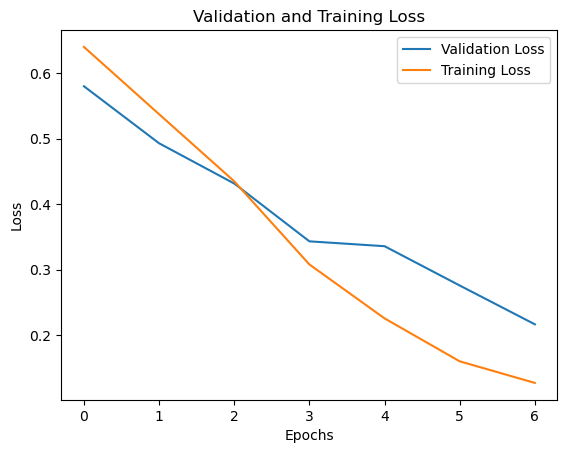

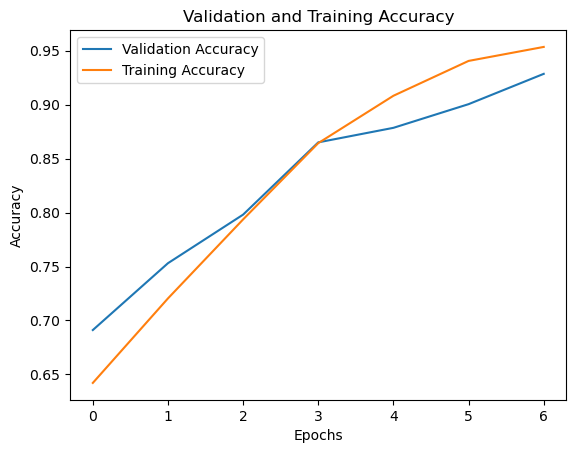

In [ ]:

# Plot the validation loss
plt.plot(history_V2.history['val_loss'], label='Validation Loss')
plt.plot(history_V2.history['loss'], label='Training Loss')
plt.title('Validation and Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.plot(history_V2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_V2.history['accuracy'], label='Training Accuracy')
plt.title('Validation and Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the model 
model_vgg16.save('trained_model/vgg16.keras')

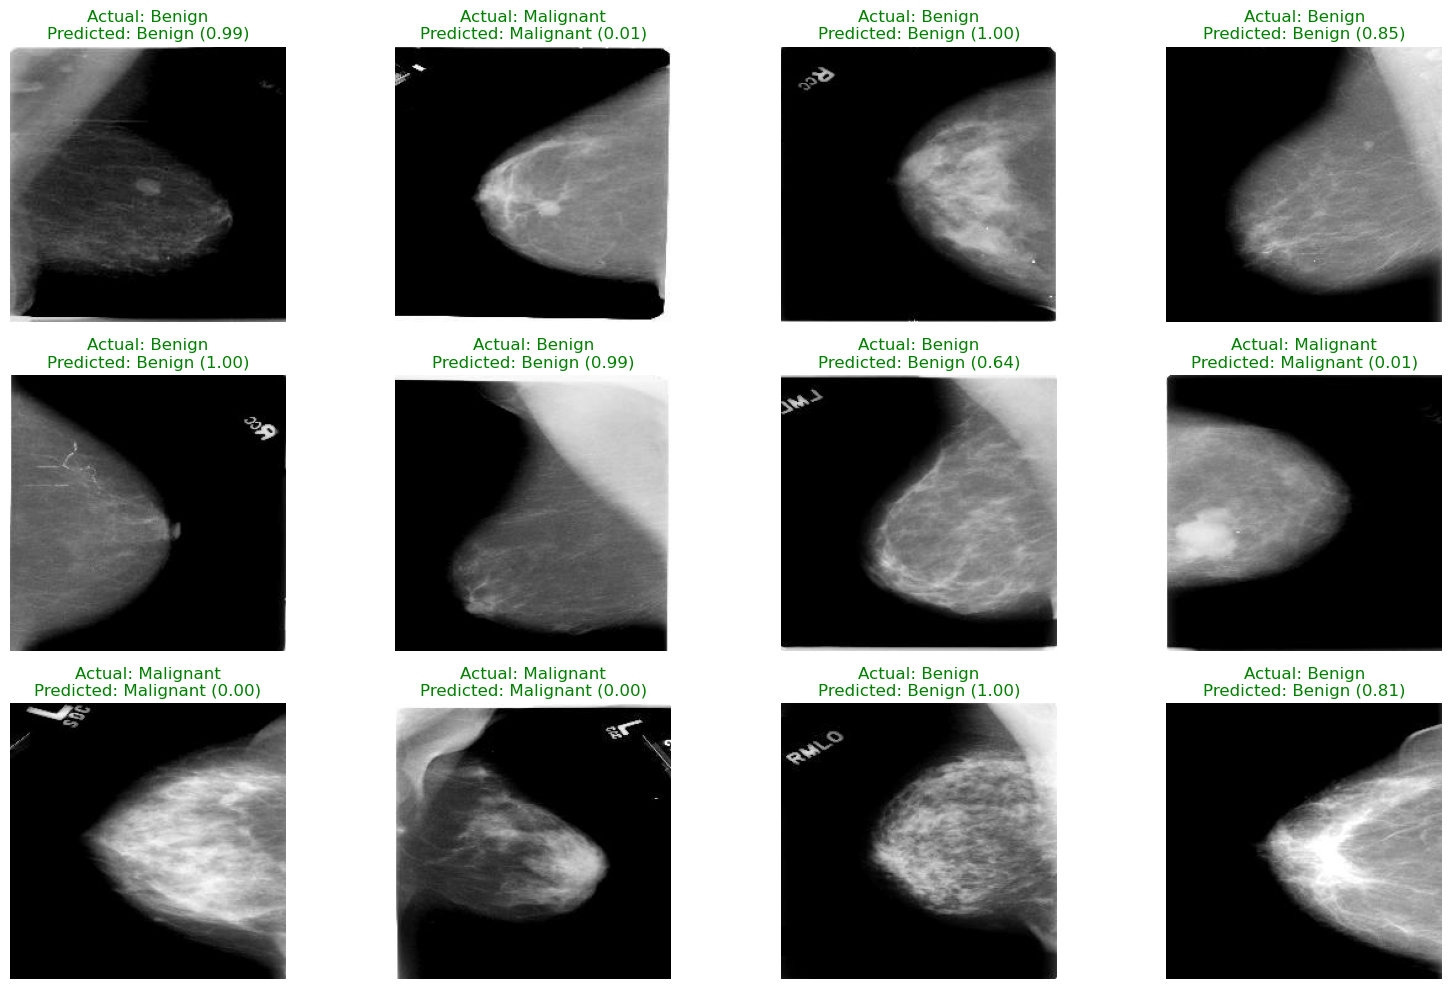

In [ ]:
# --- Load model ---
model = tf.keras.models.load_model("trained_model/vgg16.keras")  

# --- Base directory ---
base_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\cbis_ddsm_dataset\merged_data"

# --- Parameters ---
img_size = (224, 224)
num_samples = 12

# random.seed(42)

# --- Collect image paths and labels ---
image_paths, labels = [], []
for label_folder in ["0", "1"]:
    folder_path = os.path.join(base_dir, label_folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder_path, fname))
            labels.append(int(label_folder))

# --- Random sample ---
sample = random.sample(list(zip(image_paths, labels)), num_samples)
sample_paths, sample_labels = zip(*sample)

# --- Preprocessing + Prediction ---
def preprocess(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img

predictions = []
original_imgs = []

for img_path in sample_paths:
    input_arr, orig = preprocess(img_path)
    pred = model.predict(input_arr, verbose=0)[0][0]
    predictions.append(pred)
    original_imgs.append(orig)

# --- Plotting ---
plt.figure(figsize=(16, 10))
for i in range(num_samples):
    plt.subplot(3, 4, i + 1)
    plt.imshow(original_imgs[i])
    actual = "Malignant" if sample_labels[i] == 1 else "Benign"
    predicted = "Malignant" if predictions[i] < 0.5 else "Benign"
    confidence = f"{predictions[i]:.2f}"
    title_color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPredicted: {predicted} ({confidence})", color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()
